In [1]:
import numpy as np
import math
import sympy as sp

import matplotlib.pyplot as plt
%matplotlib inline

### Generalization Error

In [ ]:
def omega(N, delta, vc_dim, growth_func):
    '''compute generalization error
    
    params:
        N : int 
            sample size
        delta : float [0, 1]
            probability that |E_out - E_in| > epsilon
        vc_dim : int
            vc dimension of the given hypothesis set
        growth_func : callable, 
            growth function N, vc_dim
    '''
    return math.sqrt(8/N * math.log(4*growth_func(2*N, vc_dim) / delta))


def growth(N, vc_dim):
    '''growth function'''
    return N ** vc_dim

In [ ]:
delta = .05
vc_dim = 10

for N in [400000, 420000, 440000, 460000, 480000]:
    epsilon = omega(N, delta, vc_dim, growth)
    print('{} : {:.3f}'.format(N, epsilon))

In [ ]:
N, vc, delta, epsilon = sp.symbols('N, vc, delta, epsilon')

In [ ]:
param_dict = {N:5, delta:.05, vc:50}

In [ ]:
Rademacher = sp.sqrt(2*sp.log(2*N*(N**vc)) / N) + sp.sqrt(2/N*sp.log(1/delta)) + 1/N - epsilon
VC_original = sp.sqrt(8/N*sp.log(4*(N**vc)/delta)) - epsilon
Parrondo = sp.sqrt((2*epsilon + sp.log(6*((2*N)**vc)/delta)) / N) - epsilon
Devroye = sp.sqrt((4*epsilon*(1+epsilon) + sp.log(4*((N**2)**vc) / delta)) / (2*N)) - epsilon

In [ ]:
sp.solve(VC_original.subs(param_dict))

In [ ]:
sp.solve(Rademacher.subs(param_dict))

In [ ]:
sp.solve(Parrondo.subs(param_dict))

In [ ]:
sp.solve(Devroye.subs(param_dict))

### Bias and Variance

In [2]:
class LinReg:
    
    def __init__(self, weights=None, bias=True):
        self.w = weights
        self.bias = bias
        
    def fit(self, X, y):
        if self.bias:
            X = np.c_[np.ones(len(X)), X]
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        self.w = np.dot(np.linalg.pinv(X), y)
        
    def predict(self, X):
        if self.bias:
            X = np.c_[np.ones(len(X)), X]
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        return np.dot(X, self.w)
    
    
def mse(y_true, y_pred):
    err = y_true - y_pred
    return np.dot(err, err) / len(err)

In [3]:
def target_func(x):
    return np.sin(np.pi*x)

In [4]:
n_samples = 10000
X_all = np.random.uniform(low=-1.0, high=1.0, size=n_samples)
y_all = target_func(X_all)

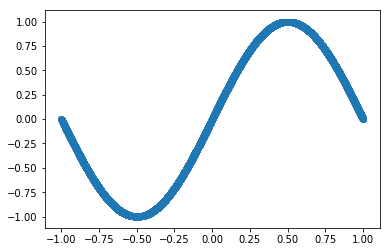

In [5]:
plt.scatter(X_all, y_all)

In [6]:
n_models = n_samples//2
X_models = np.random.uniform(low=-1, high=1, size=n_models*2)
y_models = target_func(X_models)
X_models = X_models.reshape(-1, 2)
y_models = y_models.reshape(-1, 2)

X_models.shape, y_models.shape

((5000, 2), (5000, 2))

In [7]:
a_models = []      # h(x) = b
b_models = []      # h(x) = ax
c_models = []      # h(x) = ax + b
d_models = []      # h(x) = ax^2
e_models = []      # h(x) = ax^2 + b
a_weights_sum = np.zeros(2)
b_weights_sum = np.zeros(1)
c_weights_sum = np.zeros(2)
d_weights_sum = np.zeros(1)
e_weights_sum = np.zeros(2)

for X, y in zip(X_models, y_models):
    # init models
    a = LinReg(bias=True)
    b = LinReg(bias=False)
    c = LinReg(bias=True)
    d = LinReg(bias=False)
    e = LinReg(bias=True)
    
    # train models
    a.fit(np.zeros_like(X), y)
    b.fit(X, y)
    c.fit(X, y)
    d.fit(X**2, y)
    e.fit(X**2, y)
    
    # store models
    a_models.append(a)
    b_models.append(b)
    c_models.append(c)
    d_models.append(d)
    e_models.append(e)
    
    # sum weights for avg_model
    a_weights_sum += a.w
    b_weights_sum += b.w
    c_weights_sum += c.w
    d_weights_sum += d.w
    e_weights_sum += e.w

In [8]:
a_bar = LinReg(weights=a_weights_sum/len(a_models), bias=True)
b_bar = LinReg(weights=b_weights_sum/len(b_models), bias=False)
c_bar = LinReg(weights=c_weights_sum/len(c_models), bias=True)
d_bar = LinReg(weights=d_weights_sum/len(d_models), bias=False)
e_bar = LinReg(weights=e_weights_sum/len(e_models), bias=True)

In [9]:
a_bar_pred = a_bar.predict(X_all)
b_bar_pred = b_bar.predict(X_all)
c_bar_pred = c_bar.predict(X_all)
d_bar_pred = d_bar.predict(X_all)
e_bar_pred = e_bar.predict(X_all)

In [10]:
a_bias = mse(y_all, a_bar_pred)
b_bias = mse(y_all, b_bar_pred)
c_bias = mse(y_all, c_bar_pred)
d_bias = mse(y_all, d_bar_pred)
e_bias = mse(y_all, e_bar_pred)

a_bias, b_bias, c_bias, d_bias, e_bias

(0.50393093390047605,
 0.26431791953904621,
 0.20852553300556434,
 0.5639044626727282,
 1.1958421430795749)

In [11]:
def model_bias(g_bar):
    return mse(y_all, g_bar.predict(X_all))

def model_variance(g_models, g_bar):
    total_var = 0
    g_bar_pred = g_bar.predict(X_all)
    for g in g_models:
        g_pred = g.predict(X_all)
        total_var += mse(g_bar_pred, g_pred)
    return total_var / len(g_models)

In [12]:
model_bias(a_bar) + model_variance(a_models, a_bar)

0.750703422816554

In [13]:
model_bias(b_bar) + model_variance(b_models, b_bar)

0.50272933726337976

In [14]:
model_bias(c_bar) + model_variance(c_models, c_bar)

1.883676822931021

In [15]:
model_bias(d_bar) + model_variance(d_models, d_bar)

20.265040555856327

In [16]:
model_bias(e_bar) + model_variance(e_models, e_bar)

55729.584135832156

In [17]:
a_bar.w

array([-0.012277,  0.      ])

In [18]:
b_bar.w.round(2)

array([ 1.42])

In [19]:
c_bar.w

array([-0.01292482,  0.77053118])

In [20]:
d_bar.w

array([-0.09018352])

In [21]:
e_bar.w

array([-0.18327544,  2.67291749])

[-1, 1, -1, 1]

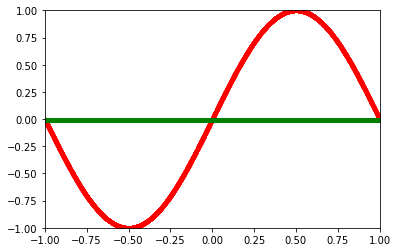

In [22]:
plt.plot(X_all, y_all, 'r.', alpha=.5)
plt.plot(X_all, a_bar.predict(X_all), 'g.', alpha=.4)
plt.axis([-1, 1, -1, 1])

[-1, 1, -1, 1]

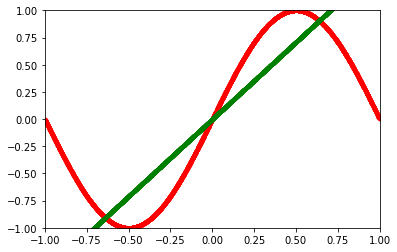

In [23]:
plt.plot(X_all, y_all, 'r.', alpha=.5)
plt.plot(X_all, b_bar.predict(X_all), 'g.', alpha=.4)
plt.axis([-1, 1, -1, 1])

[-1, 1, -1, 1]

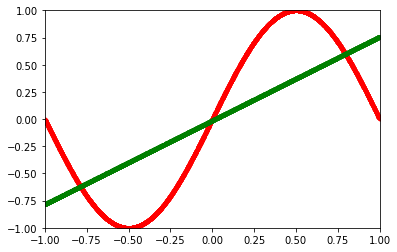

In [24]:
plt.plot(X_all, y_all, 'r.', alpha=.5)
plt.plot(X_all, c_bar.predict(X_all), 'g.', alpha=.4)
plt.axis([-1, 1, -1, 1])

[-1, 1, -1, 1]

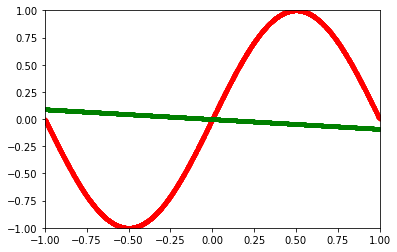

In [25]:
plt.plot(X_all, y_all, 'r.', alpha=.5)
plt.plot(X_all, d_bar.predict(X_all), 'g.', alpha=.4)
plt.axis([-1, 1, -1, 1])

[-1, 1, -1, 1]

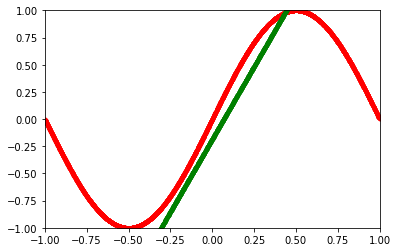

In [26]:
plt.plot(X_all, y_all, 'r.', alpha=.5)
plt.plot(X_all, e_bar.predict(X_all), 'g.', alpha=.4)
plt.axis([-1, 1, -1, 1])

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
m = LinearRegression(fit_intercept=False)

In [31]:
w_sum = np.zeros(1)
for X, y in zip(X_models, y_models):
    m.fit(X[:, np.newaxis], y)
    w_sum += m.coef_

In [32]:
w_sum / len(X_models)

array([ 1.41868654])

### VC Dimension

In [33]:
from scipy.misc import comb

In [36]:
N = 5
for k in range(N+1):
    print(comb(N, k))

1.0
5.0
10.0
10.0
5.0
1.0


In [46]:
def my_growth(N, q):
    if N == 1:
        return 2
    return 2*my_growth(N-1, q) - comb(N-1, q)

def growth(N, vc):
    result = 0
    for k in range(vc+1):
        result += comb(N, k)
    return result

In [42]:
q = 3

In [43]:
my_growth(1, q)

2

In [44]:
my_growth(2, q)

4.0

In [50]:
for n in range(1, 10):
    print(my_growth(n, q=3))

2
4.0
8.0
15.0
26.0
42.0
64.0
93.0
130.0


In [51]:
for n in range(1, 10):
    print(growth(n, vc=3))

2.0
4.0
8.0
15.0
26.0
42.0
64.0
93.0
130.0
